#Project L: What makes a playlist popular?

*Group 9: Chelsea Chen, Mengyuan Li, Xinran Tang, Jing Xu*


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import time
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ast import literal_eval
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import nltk
nltk.download('stopwords')

!pip install bioinfokit
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 84 kB 3.2 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56749 sha256=355724cd8296b80cd15718cd4f89c5b58a84bdd0088dd01284742fcc7758e6e5
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=6dfd4bb09112392e7f84f4040ab1e7e6f33914cee3961346ad9df1dcc162d82b
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!ln -s "/content/drive/MyDrive/playlists" "/content"


# Data Cleaning

## Sample playlists for the final milestone

In [ ]:
def get_trackid(tracks):
  return [track['track_uri'][14:] for track in tracks]
def get_albumid(tracks):
  return [track['album_uri'][14:] for track in tracks]
def get_artistid(tracks):
  return [track['artist_uri'][15:] for track in tracks]


In [ ]:

playlists_columns = ["name", "collaborative", "modified_at", "duration_s", "num_edits", "num_artists", "artistids", "num_albums", "albumids", "num_tracks", "trackids", "description", "num_followers" ]

start_time = time.time()
dfs = []
for i in range(1, 1000, 1):
  if i % 50 == 0:
    df_concat = pd.concat(dfs, axis = 0)
    df_concat.to_csv(f"playlists/playlists-{i//50}.csv")
    print(f"{i}: using time {time.time() - start_time}")
    start_time = time.time()
    dfs = []


  file_path = f'data/mpd.slice.{i}000-{i}999.json'
  data = json.load(open(file_path))
  df = pd.DataFrame(data["playlists"])
  df_playlists = df.set_index(["pid"])
  df_playlists["modified_at"] = pd.to_datetime(df_playlists["modified_at"],unit='s')
  df_playlists["duration_s"] = df_playlists["duration_ms"] / 1000
  df_playlists["collaborative"] = df_playlists["collaborative"].astype(bool)
  df_playlists["trackids"] = df_playlists["tracks"].apply(get_trackid)
  df_playlists["albumids"] = df_playlists["tracks"].apply(get_albumid)
  df_playlists["artistids"] = df_playlists["tracks"].apply(get_artistid)
  df_playlists = df_playlists[playlists_columns]
  # print(f'len: {len(df_playlists[df_playlists["num_followers"]>1])} + {len(df_playlists[df_playlists["num_followers"]==1])//10}')
  dfs.append(df_playlists[df_playlists["num_followers"]>1])
  dfs.append(df_playlists[df_playlists["num_followers"]==1].sample(len(df_playlists[df_playlists["num_followers"]==1])//10))


50: using time 25.181811094284058
100: using time 75.70013451576233
150: using time 71.96914291381836
200: using time 78.73762774467468
250: using time 75.63618111610413
300: using time 74.64627623558044
350: using time 72.15630102157593
400: using time 72.97620296478271
450: using time 72.10731863975525
500: using time 74.45414686203003
550: using time 70.19183707237244
600: using time 81.47203755378723
650: using time 76.3329427242279
700: using time 78.19050765037537
750: using time 72.82552528381348
800: using time 78.96258592605591
850: using time 79.30516147613525
900: using time 78.53323006629944
950: using time 81.07798933982849


In [ ]:
df_s = []
for i in range(1, 20, 1):
  df_ = pd.read_csv(f"playlists/playlists-{i}.csv")
  df_majority = df_[df_.num_followers<=10]
  df_minority = df_[df_.num_followers>10]
  df_downsampled = pd.concat([df_majority.sample(round(len(df_majority)*0.05)), df_minority])
  df_s.append(df_downsampled)

df_sub = pd.concat(df_s)
df_sub.head()

pid        name  ...  description num_followers
13889  44429         ACL  ...          NaN             2
13306  42757  volleyball  ...          NaN             4
13916  44596        5sos  ...          NaN             2
252     1995         woo  ...          NaN             2
12210  39203     driving  ...          NaN             2

[5 rows x 14 columns]

## Get more features for sampled data

In [ ]:
df = pd.read_csv("playlists_final.csv", index_col=0)
from ast import literal_eval
df["trackids"] = df["trackids"].apply(literal_eval)
df["albumids"] = df["albumids"].apply(literal_eval)
df["artistids"] = df["artistids"].apply(literal_eval)
df["tracks"] = df["trackids"].apply(lambda x: [{"trackid": x[i], "pos": i} for i in range(len(x))])
df_playlists = df

# df_full
df_full = df.explode("tracks").reset_index()
df_full = pd.concat([df_full.drop(columns = ["tracks"]),pd.json_normalize(df_full["tracks"])], axis = 1)

df_full["albumid"] = df_full["albumids"]
df_full["artistid"] = df_full["artistids"]
df_full["modified_at"] = pd.to_datetime(df_full["modified_at"])
df_full["collaborative"] = df_full["collaborative"].astype(bool)
df_full["playlist_name"] = df_full["name"]



In [ ]:
df_full = df_full.drop(columns = ["name",  "trackids","albumids","artistids"])

In [ ]:
tracks_columns = ['tid', 'track_name', 'artist_name', 'album_name', 'playlists', 'pos_lists', 'duration_s', 'album_uri', 'artist_uri', 'track_uri']
df_tracks = df_full.groupby(by=["trackid"]).agg({
    'pid': lambda x: list(x),
    'playlist_name': lambda x: list(x),
    'pos': lambda x: list(x),
    #'artist_name': 'first',
    'artistid': 'first',
    #'track_name': 'first',
    'albumid': 'first',
    #'album_name': 'first',
})

df_tracks["track_uri"] = "spotify:track:"+ df_tracks.index


In [ ]:
df_tracks

pid  ...                             track_uri
trackid                                                                    ...                                      
0007AYhg2UQbEm88mxu7js                                            [88823]  ...  spotify:track:0007AYhg2UQbEm88mxu7js
000By3h9rDTPo99LViMEqQ                                           [791891]  ...  spotify:track:000By3h9rDTPo99LViMEqQ
000OMscDzUz5gjIIruXEWg                                           [352002]  ...  spotify:track:000OMscDzUz5gjIIruXEWg
000VZqvXwT0YNqKk7iG2GS                                   [555115, 880916]  ...  spotify:track:000VZqvXwT0YNqKk7iG2GS
000xQL6tZNLJzIrtIgxqSl  [9695, 27256, 20317, 22342, 49785, 24905, 1011...  ...  spotify:track:000xQL6tZNLJzIrtIgxqSl
...                                                                   ...  ...                                   ...
7zzD8MpgOd9qd3i3fspKlf                                           [244857]  ...  spotify:track:7zzD8MpgOd9qd3i3fspKlf
7zzSsdYQCM2ZYQ9krf2Ptt                                           [145983]  ...  spotify:track:7zzSsdYQCM2ZYQ9krf2Ptt
7zzcv2R8B6FHLHKakRvegL                                           [949278]  ...  spotify:track:7zzcv2R8B6FHLHKakRvegL
7zzmpRP0WkYge45l6LTQ8i                                   [711613, 900867]  ...  spotify:track:7zzmpRP0WkYge45l6LTQ8i
7zzpwV2lgKsLke68yFoZdp                                           [672895]  ...  spotify:track:7zzpwV2lgKsLke68yFoZdp

[332262 rows x 6 columns]

In [ ]:

client_credentials_manager = SpotifyClientCredentials(client_id='ec13b67d77e04f158fba98985949b18e', client_secret='b8897307750c451eacb662a548affed2')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
# DO NOT RUN
total_tracks_audio_features = []
tracks_audio_features = []

for i, track_uri in enumerate(df_tracks['track_uri'].unique().tolist()):
  if i % 500 == 0 and i != 0:
    print(i)
    total_tracks_audio_features.append(tracks_audio_features)
    tracks_audio_features = []
  try:
    tracks_audio_features.append(sp.audio_features(tracks= track_uri)[0])
  except Exception:
    tracks_audio_features.append([])
  

In [ ]:
total = []
for each in total_tracks_audio_features:
  if len(each) <= 0:
    continue
  each_ = []
  for row in each:
    if row is None or len(row) <= 0:
      continue
    each_.append(row)
  total.append(each_)
for each in total_tracks_audio_features2:
  if len(each) <= 0:
    continue
  each_ = []
  for row in each:
    if row is None or len(row) <= 0:
      continue
    each_.append(row)
  total.append(each_)

In [ ]:
df_tracks_audio_features = [pd.DataFrame(tracks_audio_features) if len(tracks_audio_features) > 0 else pd.DataFrame() for tracks_audio_features in total]
df_tracks_audio_features = pd.concat(df_tracks_audio_features).drop(columns=["uri", "type", "track_href"])
df_tracks_audio_features.to_csv("audio_features_final.csv")
df_tracks_audio_features

danceability  energy  ...  duration_ms  time_signature
0           0.648   0.598  ...       198000               4
1           0.751   0.440  ...       217451               4
2           0.695   0.901  ...       310533               4
3           0.444   0.991  ...       256478               4
4           0.748   0.627  ...       188491               4
..            ...     ...  ...          ...             ...
495         0.573   0.950  ...       233829               4
496         0.520   0.113  ...       232267               4
497         0.494   0.689  ...       227733               4
498         0.584   0.805  ...       100027               4
499         0.490   0.993  ...       231587               4

[331990 rows x 15 columns]

In [ ]:
df_tracks_merged.describe()

Unnamed: 0   danceability  ...  time_signature  artist_popularity
count  335619.000000  335619.000000  ...   335619.000000      335619.000000
mean      249.524815       0.567974  ...        3.902812          50.586981
std       144.311326       0.174718  ...        0.420457          21.222899
min         0.000000       0.000000  ...        0.000000           0.000000
25%       125.000000       0.455000  ...        4.000000          38.000000
50%       249.000000       0.580000  ...        4.000000          53.000000
75%       374.000000       0.697000  ...        4.000000          66.000000
max       499.000000       0.991000  ...        5.000000         100.000000

[8 rows x 15 columns]

In [ ]:
# DO NOT RUN
df_tracks["artist_uri"] = "spotify:artist:"+ df_tracks.artistid
df_tracks.artist_uri
total = []
sub = []

for i, uri in enumerate(df_tracks['artist_uri'].unique().tolist()):
  if i % 500 == 0 and i != 0:
    print(i)
    total.append(sub)
    sub = []
  try:
    artist = sp.artist(uri)
    artist.pop("images", "No Key Found")
    artist.pop("external_urls", "No Key Found")
    sub.append(artist)
  except Exception:
    sub.append([])

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000


In [ ]:
# DO NOT RUN
df_tracks["album_uri"] = "spotify:album:"+ df_tracks.albumid

total = []
sub = []

for i, uri in enumerate(df_tracks['album_uri'].unique().tolist()):
  if i % 500 == 0 and i != 0:
    print(i)
    total.append(sub)
    sub = []
  try:
    album = sp.album(uri)
    album.pop("artists", "No Key Found")
    album.pop("images", "No Key Found")
    album.pop("tracks", "No Key Found")
    album.pop("external_urls", "No Key Found")
    sub.append(album)
  except Exception:
    sub.append([])


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000


HTTP Error for GET to https://api.spotify.com/v1/albums/3YJTgSIQe9amgygRxAFKd6 with Params: {} returned 404 due to non existing id


13500
14000
14500
15000
15500
16000
16500
17000
17500


HTTP Error for GET to https://api.spotify.com/v1/albums/37vuaFNpVS1TVh3thZ9R9v with Params: {} returned 404 due to non existing id


18000


HTTP Error for GET to https://api.spotify.com/v1/albums/5nt4DzDwomrEimcP5fmWnX with Params: {} returned 404 due to non existing id


18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500


HTTP Error for GET to https://api.spotify.com/v1/albums/37sMthfYf1LB3sE9hMg81e with Params: {} returned 404 due to non existing id
HTTP Error for GET to https://api.spotify.com/v1/albums/0d2gl9PEOkxt157oEWmoKT with Params: {} returned 404 due to non existing id


24000
24500
25000
25500
26000
26500
27000


HTTP Error for GET to https://api.spotify.com/v1/albums/6dDzrN8WVEXdcj9HrzWngI with Params: {} returned 404 due to non existing id


27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000


HTTP Error for GET to https://api.spotify.com/v1/albums/4QQjAJPDXIiPoALcGQDdVT with Params: {} returned 404 due to non existing id


34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500


HTTP Error for GET to https://api.spotify.com/v1/albums/2NF8nUtEclahXcTbrY4I2e with Params: {} returned 404 due to non existing id


40000
40500
41000
41500


HTTP Error for GET to https://api.spotify.com/v1/albums/5AqWjXNXhidqSoiQiaT65U with Params: {} returned 404 due to non existing id
HTTP Error for GET to https://api.spotify.com/v1/albums/2IfURf7MbHdJDKqCw6BCVE with Params: {} returned 404 due to non existing id


42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000


HTTP Error for GET to https://api.spotify.com/v1/albums/3EYNeQRfAPmSKUP7WMkCyV with Params: {} returned 404 due to non existing id


47500


HTTP Error for GET to https://api.spotify.com/v1/albums/1RTmlLvDBdkBirKzNBfGSQ with Params: {} returned 404 due to non existing id


48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000


HTTP Error for GET to https://api.spotify.com/v1/albums/3g8lHAGLyNgOkjplsHmUom with Params: {} returned 404 due to non existing id


54500
55000
55500
56000
56500


HTTP Error for GET to https://api.spotify.com/v1/albums/46SKZL0hYnIeMo2Insp2Zn with Params: {} returned 404 due to non existing id


57000
57500
58000
58500
59000
59500
60000
60500
61000


HTTP Error for GET to https://api.spotify.com/v1/albums/6teLJSRUNu0IbxGaxOitn5 with Params: {} returned 404 due to non existing id


61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000


HTTP Error for GET to https://api.spotify.com/v1/albums/1reFoVy9oNEoA7mMMQtWNR with Params: {} returned 404 due to non existing id


68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500


HTTP Error for GET to https://api.spotify.com/v1/albums/7EEp3B32oSOqCWQ4MLQH3K with Params: {} returned 404 due to non existing id
HTTP Error for GET to https://api.spotify.com/v1/albums/1shdpGlbznYM4gqN2HN0gz with Params: {} returned 404 due to non existing id


75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500


HTTP Error for GET to https://api.spotify.com/v1/albums/4KJWlqY4rtgWDTtIdot2iR with Params: {} returned 404 due to non existing id


85000
85500
86000
86500
87000
87500
88000
88500
89000
89500
90000
90500
91000
91500
92000


HTTP Error for GET to https://api.spotify.com/v1/albums/6RrOQzX6FHjnOHpVmG8HvU with Params: {} returned 404 due to non existing id


92500
93000
93500
94000
94500


HTTP Error for GET to https://api.spotify.com/v1/albums/4HHVyorV6hUt9N0McXlIog with Params: {} returned 404 due to non existing id


95000
95500
96000
96500
97000
97500
98000
98500
99000
99500
100000
100500
101000
101500
102000
102500
103000
103500


HTTP Error for GET to https://api.spotify.com/v1/albums/2cLONCtAXECVarJYY585bY with Params: {} returned 404 due to non existing id


104000
104500
105000
105500
106000
106500
107000
107500
108000
108500
109000
109500
110000


HTTP Error for GET to https://api.spotify.com/v1/albums/4kDwnpHjy0ZHjv6HJwDVI2 with Params: {} returned 404 due to non existing id


110500
111000
111500
112000
112500
113000


HTTP Error for GET to https://api.spotify.com/v1/albums/1HrDbtxv9EhDZDbRsmTBGj with Params: {} returned 404 due to non existing id


113500
114000


HTTP Error for GET to https://api.spotify.com/v1/albums/2ZXSsCkAl6loh6BYKhnt2X with Params: {} returned 404 due to non existing id


114500
115000


HTTP Error for GET to https://api.spotify.com/v1/albums/6JeWSH9E44VmYnAanFchUd with Params: {} returned 404 due to non existing id


115500
116000
116500
117000


HTTP Error for GET to https://api.spotify.com/v1/albums/6HoX2FB2D3l7nhgzi9OXRW with Params: {} returned 404 due to non existing id


117500
118000


HTTP Error for GET to https://api.spotify.com/v1/albums/38BqFGCrc9lPzonRXlV8lZ with Params: {} returned 404 due to non existing id


118500
119000
119500
120000
120500
121000


HTTP Error for GET to https://api.spotify.com/v1/albums/7MqXhJ6cwDRCmBIczTpX57 with Params: {} returned 404 due to non existing id


121500
122000
122500
123000
123500
124000
124500
125000
125500


HTTP Error for GET to https://api.spotify.com/v1/albums/0yBGjedQ95TVG2E2xd3iWi with Params: {} returned 404 due to non existing id


126000
126500
127000
127500
128000


HTTP Error for GET to https://api.spotify.com/v1/albums/2c1jB8QZ9uIkE8ZKWsYpRs with Params: {} returned 404 due to non existing id


128500


HTTP Error for GET to https://api.spotify.com/v1/albums/5BDkiehAFHiDsoV1fqcYSo with Params: {} returned 404 due to non existing id


129000
129500
130000
130500
131000
131500
132000


HTTP Error for GET to https://api.spotify.com/v1/albums/40gJCRu9aeOfx1x0eL67kr with Params: {} returned 404 due to non existing id


132500
133000
133500
134000


HTTP Error for GET to https://api.spotify.com/v1/albums/2028oSI6Trj5AkdyCNA3bP with Params: {} returned 404 due to non existing id


134500
135000
135500
136000
136500
137000
137500
138000
138500


HTTP Error for GET to https://api.spotify.com/v1/albums/1l1t5kTRylKNFQ0xBN95Y7 with Params: {} returned 404 due to non existing id


139000
139500
140000
140500
141000
141500


HTTP Error for GET to https://api.spotify.com/v1/albums/3KrdU9sQH6RW1D5ZmOyDXc with Params: {} returned 404 due to non existing id


142000
142500
143000
143500
144000
144500
145000
145500
146000
146500


HTTP Error for GET to https://api.spotify.com/v1/albums/35ilJXQcDRq8lCmjYPWXBl with Params: {} returned 404 due to non existing id


147000
147500
148000
148500
149000
149500
150000


In [ ]:
df_artists = []
for each in total:
  if len(each) <= 0:
    continue
  each_ = []
  for row in each:
    if len(row) <= 0:
      continue
    if isinstance(row["followers"], dict):
      row["followers"] = row["followers"]["total"]
    if isinstance(row["followers"], list):
      row["followers"] = row["followers"][0]
    row["genres"] = "|".join(row["genres"])
    each_.append(row)
  df_artists.append(pd.DataFrame(each_))
len(df_artists)
df_artists = pd.concat(df_artists)



In [ ]:
df_artists

followers  ...                                    uri
0      482737  ...  spotify:artist:6eXZu6O7nAUA5z6vLV8NKI
1         863  ...  spotify:artist:7r1ya5BBz31eNt2GBl3GFC
2       86008  ...  spotify:artist:5zExRf0VQCl3GO4Jrj8r0s
3      262749  ...  spotify:artist:6kQB2RN7WwryMdJ1MoQh1E
4    18090923  ...  spotify:artist:5ZsFI1h6hIdQRw2ti0hz81
..        ...  ...                                    ...
495     46604  ...  spotify:artist:3GfMoNg8qvtTuarY4ILTzm
496        73  ...  spotify:artist:52gcMUmJNB3Q6NG0jPWj0b
497      7218  ...  spotify:artist:1Jc2HsPucRk1x7lAUd7xma
498     12911  ...  spotify:artist:2bUUwnuZ9pezPvPzGwanok
499      1838  ...  spotify:artist:4z7e70ePkn05YNMNAXm5t9

[62997 rows x 8 columns]

In [ ]:
df_tracks_csv = pd.read_csv("playlists/tracks_final.csv",index_col=0)
df_tracks_csv.head()
df_artists = pd.read_csv("playlists/artists_final.csv",index_col=0)
df_artists["artist_name"] = df_artists["name"]
df_artists["artist_popularity"] = df_artists["popularity"]
df_artists["artist_followers"] = df_artists["followers"].apply(literal_eval).apply(lambda x: x["total"] if type(x) is dict else x)

df_artists["artist_genres"] = df_artists["genres"]
df_tracks_final = df_tracks_csv.merge(df_artists.drop(columns=["name", "popularity", "followers", "genres", "uri", "type", "href"]),left_on=df_tracks_csv.artistid, right_on=df_artists['id']).drop(columns=["key_0","id"])


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df_tracks_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788171 entries, 0 to 1788170
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   pid                int64 
 1   collaborative      bool  
 2   num_edits          int64 
 3   trackid            object
 4   pos                int64 
 5   albumid            object
 6   artistid           object
 7   playlist_name      object
 8   artist_name        object
 9   artist_popularity  int64 
 10  artist_followers   int64 
 11  artist_genres      object
dtypes: bool(1), int64(5), object(6)
memory usage: 165.4+ MB


In [ ]:
df_tracks.reset_index().to_csv("playlists/tracks_artists.csv")

In [ ]:
df_artists = pd.read_csv("playlists/artists_final.csv",index_col=0)
df_artists["artist_name"] = df_artists["name"]
df_artists["artist_popularity"] = df_artists["popularity"]
df_artists["artist_followers"] = df_artists["followers"]
df_artists["artist_genres"] = df_artists["genres"]


followers  ...                                    uri
0      482737  ...  spotify:artist:6eXZu6O7nAUA5z6vLV8NKI
1         863  ...  spotify:artist:7r1ya5BBz31eNt2GBl3GFC
2       86008  ...  spotify:artist:5zExRf0VQCl3GO4Jrj8r0s
3      262749  ...  spotify:artist:6kQB2RN7WwryMdJ1MoQh1E
4    18090923  ...  spotify:artist:5ZsFI1h6hIdQRw2ti0hz81
..        ...  ...                                    ...
495     46604  ...  spotify:artist:3GfMoNg8qvtTuarY4ILTzm
496        73  ...  spotify:artist:52gcMUmJNB3Q6NG0jPWj0b
497      7218  ...  spotify:artist:1Jc2HsPucRk1x7lAUd7xma
498     12911  ...  spotify:artist:2bUUwnuZ9pezPvPzGwanok
499      1838  ...  spotify:artist:4z7e70ePkn05YNMNAXm5t9

[62997 rows x 8 columns]

Finally, we fetched:
1. artist information per track in each playlist
2. album information per track in each playlist
3. audio features per track in each playlist

# EDA

In [ ]:
df_playlists = pd.read_csv("/content/playlists/playlists_final.csv")
display(df_playlists.info())
display(df_playlists.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21069 entries, 0 to 21068
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pid            21069 non-null  int64  
 1   name           21069 non-null  object 
 2   collaborative  21069 non-null  bool   
 3   modified_at    21069 non-null  object 
 4   duration_s     21069 non-null  float64
 5   num_edits      21069 non-null  int64  
 6   num_artists    21069 non-null  int64  
 7   artistids      21069 non-null  object 
 8   num_albums     21069 non-null  int64  
 9   albumids       21069 non-null  object 
 10  num_tracks     21069 non-null  int64  
 11  trackids       21069 non-null  object 
 12  description    1029 non-null   object 
 13  num_followers  21069 non-null  int64  
dtypes: bool(1), float64(1), int64(6), object(6)
memory usage: 2.1+ MB


None

pid        name  ...  description num_followers
0  44429         ACL  ...          NaN             2
1  42757  volleyball  ...          NaN             4
2  44596        5sos  ...          NaN             2
3   1995         woo  ...          NaN             2
4  39203     driving  ...          NaN             2

[5 rows x 14 columns]

**First look at the original playlists dataset after downsample**

In [ ]:
df_playlists.describe()

pid     duration_s  ...    num_tracks  num_followers
count   21069.000000   21069.000000  ...  21069.000000   21069.000000
mean   475172.292373   19669.034193  ...     83.538421      55.141393
std    273034.511616   14568.157248  ...     60.434735     881.165787
min      1001.000000     774.184000  ...      5.000000       1.000000
25%    240637.000000    7987.763000  ...     34.000000       2.000000
50%    472626.000000   15608.348000  ...     67.000000       2.000000
75%    710383.000000   28181.198000  ...    120.000000      12.000000
max    949993.000000  167890.905000  ...    250.000000   71643.000000

[8 rows x 7 columns]

From the statistical describution we can see that the predictors `pid`,	`duration_s`, `num_edits`, `num_artists`, `num_album`, `num_tracks` all have a wide range, and the response `num_followers` also varies a lot. 

## Distribution of the response variable

In [ ]:
response = df_playlists['num_followers']

In [ ]:
response.value_counts()/response.shape[0]

2       0.332906
1       0.169538
3       0.108643
4       0.043808
11      0.037021
          ...   
1806    0.000047
1470    0.000047
2088    0.000047
1150    0.000047
3934    0.000047
Name: num_followers, Length: 601, dtype: float64

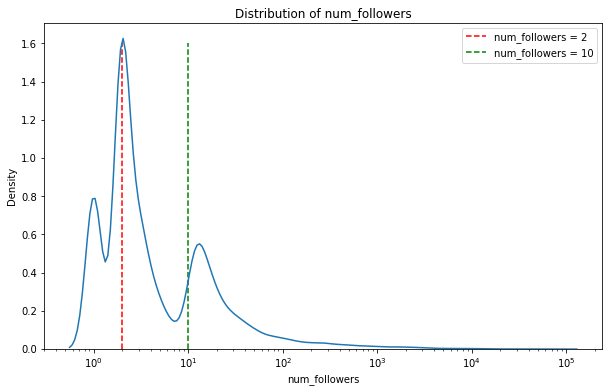

In [ ]:
#distribution of num_followers
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.kdeplot(response.values,log_scale=True, ax=ax)
ax.vlines(x=2, ymin=0.0, ymax=1.6, colors='red', linestyles='--',label = "num_followers = 2")
ax.vlines(x=10, ymin=0.0, ymax=1.6, colors='green', linestyles='--',label = "num_followers = 10")
ax.set_xlabel("num_followers")
ax.set_title("Distribution of num_followers")
ax.legend()

From the above plot we can see that most of the playlists only have a few number of followers, in terms of numbers, lower or around one hundred. Also, from the position of peak density, single-digit followers forms the largest  part in the data. This is reasonable since we can image that for most of the playlists, they are just "private" for users, not able to be a hit. However, for the popular playlists, we want to find their common features such as a specific theme, or contains a lot of famous artists.


To make the ratio of "popular" playlists and "unpopular" playlists keep the same after we do the train test split, we create a catogorical label which indicates the level of popularity of this playlist. When we have to do the train test split, we will stratify by this label.

In [ ]:
df_playlists['popularity_level'] = 'medium'
df_playlists.loc[df_playlists['num_followers']>10,'popularity_level'] = 'high'
df_playlists.loc[df_playlists['num_followers']==1,'popularity_level'] = 'low'
# df_playlists.to_csv("/content/playlists/playlists_level.csv")

- From the basic information of this dataset, we noticed that many playlists do not contain a description. So we created a feature `have_description` to discriminate these playlists.

- Also, the distribution of `num_followers` is very skewed, it is better to use log10(num_followers) to be the response variable.


In [ ]:
datacopy = df_playlists.copy()
datacopy['have_description'] = True
datacopy.loc[datacopy['description'].isna(),'have_description'] = False
datacopy['log_followers'] = np.log10(datacopy['num_followers'])
# datacopy

## Scatterplot for continuous features

In [ ]:
continuous_playlists_features = ['duration_s','num_edits','num_artists','num_albums','num_tracks']
text_features = ['name', 'description']
bool_features = ['collaborative','have_description']
time_features = ['modified_at']
list_features = ['artistids', 'albumids', 'trackids'] #join
catogrical_response = 'popularity_level'

logresponse = 'log_followers'
response = 'num_followers'

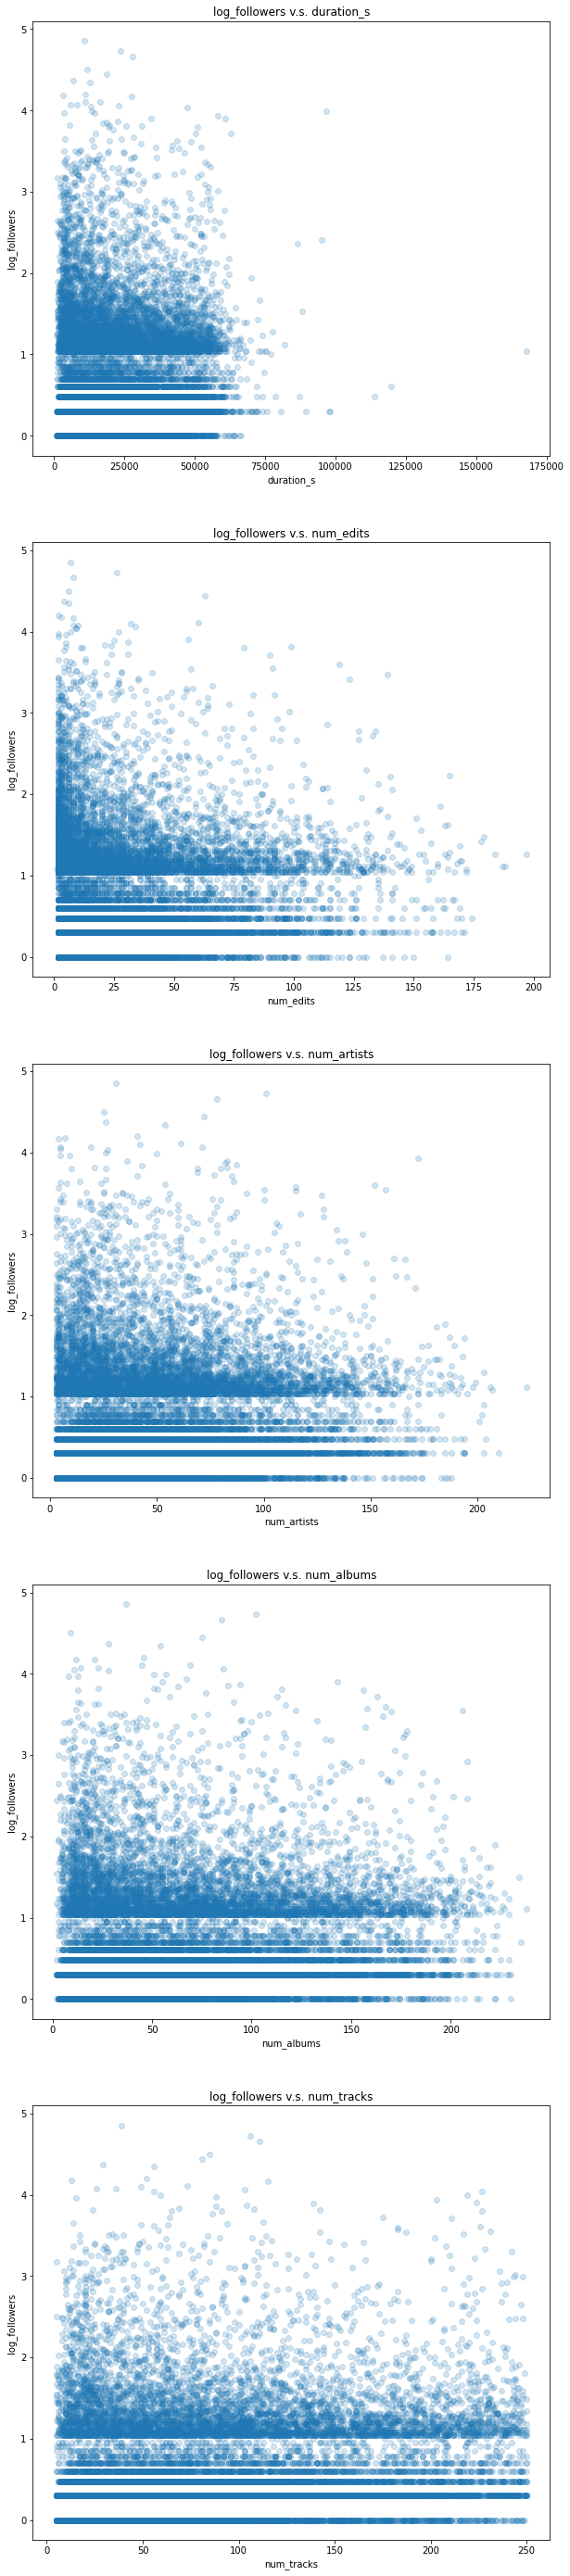

In [ ]:
def continuous_fig(feature,i):
  ax[i].scatter(datacopy[feature],datacopy[logresponse],alpha = 0.2)
  ax[i].set_xlabel(feature)
  ax[i].set_ylabel(logresponse)
  ax[i].set_title(f'{logresponse} v.s. {feature}')

fig,ax = plt.subplots(5,1,figsize=(10,50))
ax.ravel()
# plt.suptitle(f'{logresponse} v.s. continuous features')

for i, feature in enumerate(continuous_playlists_features):
  continuous_fig(feature,i)

Here we want to take a closer look at the relationship between number of followers and continuous features. Due to the large scale of the response, we take log of it.

For predictor `duration_s`, we can see a slight trend that longer playlist may result in fewer followers. And for predictors `num_edits`, `num_artists`, `num_albums`, the relationship related to the response is more obvious that more edits, artists or albums in the playlist, the fewer followers is it likely to receive. However, we point out that here larger number of duration, edits, artists and albums in a playlist has a smaller dataset, thus exploiting these trends is not conclusive.

Predictor `num_tracks` shows the least relationship between number of followers since we cannot find a clear trend in the data. The data is almost evenly distributed, which means this variable contains little information that we want.

Those obserations tell us that users may more likely to follow a playlist that focus on several artists or albums, and does not have too many songs. This still make sense since we can image that many people want to choose songs that meet their taste, and similar types of artists and albums is a good choice. Also, an overly lengthy playlist will use up listeners' patience if they find the first few song are not good.

## Boxplot for catogorical features

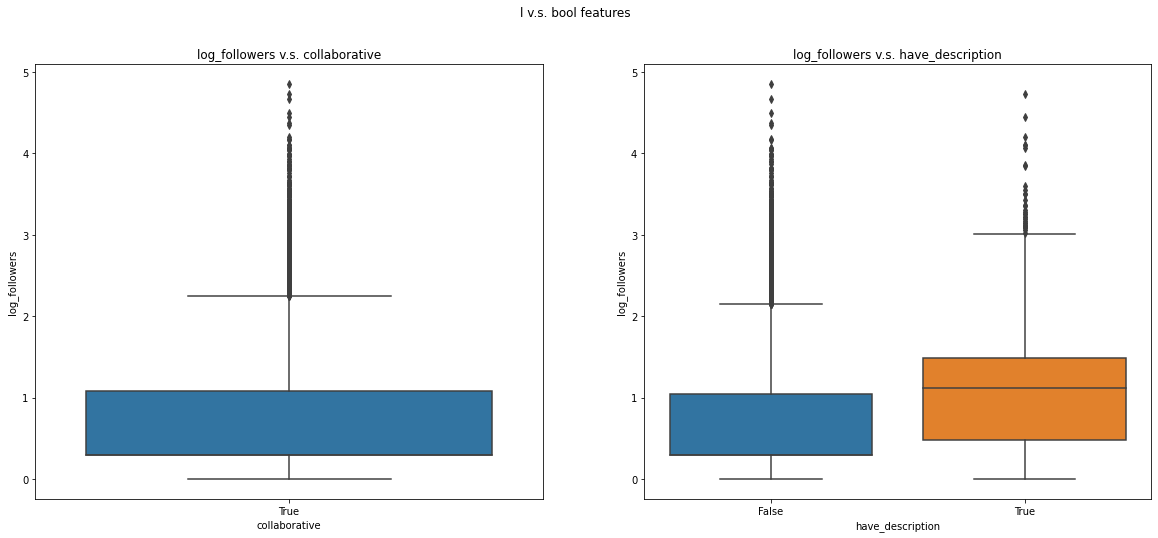

In [ ]:
def bool_fig(feature,i):
  sns.boxplot(x=feature,y=logresponse, data=datacopy,ax=ax[i])
  
  ax[i].set_xlabel(feature)
  ax[i].set_ylabel(logresponse)
  ax[i].set_title(f'{logresponse} v.s. {feature}')

fig,ax = plt.subplots(1,2,figsize=(20,8))
ax.ravel()
plt.suptitle(f'{logresponse[0]} v.s. bool features')

for i, feature in enumerate(bool_features):
  bool_fig(feature,i)

Since all the playlists are collaborated, this variable is not indicative and will not be considered in our model.

For the playlists that having description, they tends to have a greater number of followers since the mean of it is slightly higher. This shows that users are more willing to take a look at playlists that have a description of the songs or theme they have. This is reasonable since strong description make playlists more attractive and help people judge if they will love them. We can extract useful information, such as types or artists from briefs and it will drives us to listen. 

## WordCloud for text features

Since the original description is dirty, we load the cleaned dataset made by ourselves to take a look at the `description`

In [ ]:
df_combine = pd.read_csv("/content/playlists/playlist_combine.csv")

**Word Cloud for all descriptions**

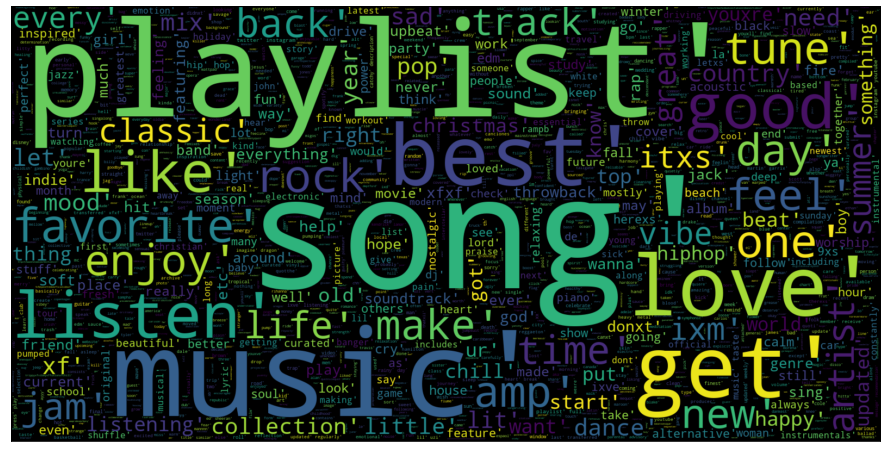

In [ ]:
plt.figure(figsize = (16,8)) 
plt.xticks([], [])  # remove tick markers on x, y axes
plt.yticks([], [])
wc_fake_text = WordCloud(max_words = 1600 , width = 1600 , height = 800 , stopwords = stopwords.words("english")).generate(" ".join(df_combine.description.dropna()))
plt.imshow(wc_fake_text, interpolation = 'bilinear')

**WordCloud for more popular playlists**

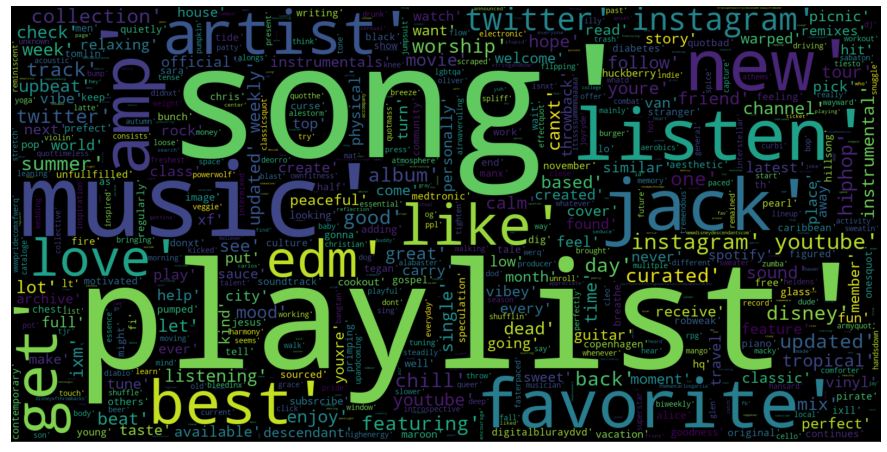

In [ ]:
plt.figure(figsize = (16,8)) 
plt.xticks([], [])  # remove tick markers on x, y axes
plt.yticks([], [])
wc_fake_text = WordCloud(max_words = 1600 , width = 1600 , height = 800 , stopwords = stopwords.words("english")).generate(" ".join(df_combine.description[df_playlists.num_followers>100].dropna()))
plt.imshow(wc_fake_text, interpolation = 'bilinear')

## Scatterplot for transformed datetime

Text(0.5, 1.0, 'Created Data v.s. log(num_followers)')

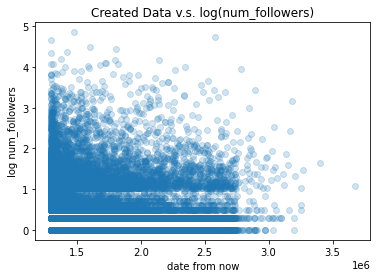

In [ ]:
plt.scatter(df_combine['modified_at_FROMNOW'],df_combine[logresponse],alpha = 0.2)
plt.xlabel("date from now")
plt.ylabel("log num_followers")
plt.title("Created Data v.s. log(num_followers)")

We fetched more related data from Spotify API, and save them in `tracks_artists_final.csv`, they are features about artist of every track.

In [ ]:
df_track_artist = pd.read_csv("/content/playlists/tracks_artists_final.csv",index_col=0)
display(df_track_artist.info())
display(df_track_artist.head(5))


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788171 entries, 0 to 1788170
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   pid                int64 
 1   collaborative      bool  
 2   num_edits          int64 
 3   trackid            object
 4   pos                int64 
 5   albumid            object
 6   artistid           object
 7   playlist_name      object
 8   artist_name        object
 9   artist_popularity  int64 
 10  artist_followers   int64 
 11  artist_genres      object
dtypes: bool(1), int64(5), object(6)
memory usage: 165.4+ MB


None

pid  ...                                      artist_genres
0   44429  ...  garage rock|modern alternative rock|modern blu...
1  122972  ...  garage rock|modern alternative rock|modern blu...
2  187223  ...  garage rock|modern alternative rock|modern blu...
3  283690  ...  garage rock|modern alternative rock|modern blu...
4  360449  ...  garage rock|modern alternative rock|modern blu...

[5 rows x 12 columns]

In [ ]:
df_track_artist.columns

Index(['pid', 'collaborative', 'num_edits', 'trackid', 'pos', 'albumid',
       'artistid', 'playlist_name', 'artist_name', 'artist_popularity',
       'artist_followers', 'artist_genres'],
      dtype='object')

In [ ]:
# group by playlist_name: 'artist_popularity', 'artist_followers'
continuous_artists_features = ['artist_popularity','artist_followers']
text_artist_features = ['artist_name', 'artist_genres']

get the mean of continuous features group by playlists

In [ ]:
add_artist_features = df_track_artist.groupby('pid').mean()[continuous_artists_features]
datacopy = datacopy.join(add_artist_features, on = 'pid')
datacopy['log_artist_followers'] = np.log10(datacopy['artist_followers'])
continuous_artists_features = ['artist_popularity','log_artist_followers']

## Scatterplot for fetched mean artist features

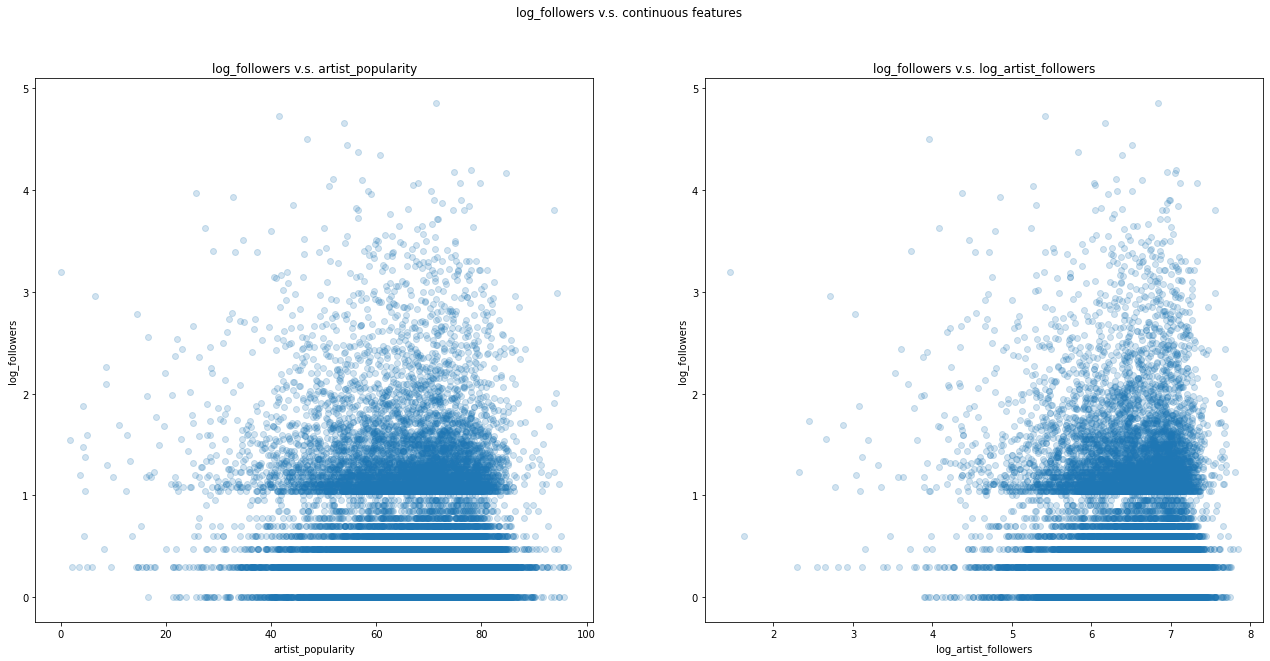

In [ ]:
def continuous_fig(feature,i):
  ax[i].scatter(datacopy[feature],datacopy[logresponse],alpha = 0.2)
  ax[i].set_xlabel(feature)
  ax[i].set_ylabel(logresponse)
  ax[i].set_title(f'{logresponse} v.s. {feature}')

fig,ax = plt.subplots(1,2,figsize=(22,10))
ax.ravel()
plt.suptitle(f'{logresponse} v.s. continuous features')

for i, feature in enumerate(continuous_artists_features):
  continuous_fig(feature,i)

The trend in above two graphs is consistent that the more popular the artist is, the number of followers is also larger. This finding is common sense since the reason that an artist is popular is mainly because his or her songs are attractive, and therefore a lot of followers. Then the playlists containing their songs seems to be more fascinating.

## Wordcloud for text artist features

In [ ]:
df_track_artist_plflw = df_track_artist.merge(df_playlists[['pid','num_followers']], on = 'pid', how='left')

In [ ]:
df_track_artist_plflw.head()

pid  ...  num_followers
0   44429  ...              2
1  122972  ...              2
2  187223  ...              1
3  283690  ...             22
4  360449  ...             14

[5 rows x 13 columns]

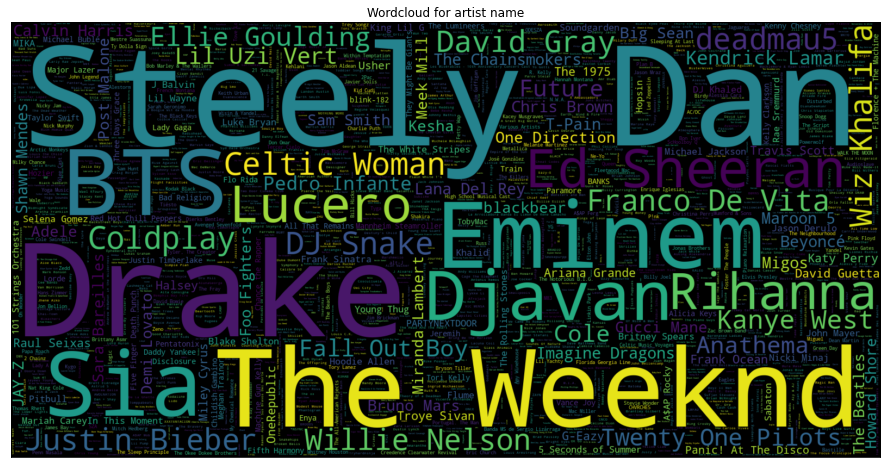

In [ ]:
plt.figure(figsize = (16,8)) 
plt.xticks([], [])  # remove tick markers on x, y axes
plt.yticks([], [])
plt.title("Wordcloud for artist name")
artists_freqs = df_track_artist_plflw['artist_name'][df_track_artist_plflw.num_followers > 100].value_counts()
artists, freqs = artists_freqs.index.values, artists_freqs.values
dd = dict(zip(artists, freqs))
wc_playlistnames = WordCloud(max_words=1600, width=1600, height=800).generate_from_frequencies(dd)
plt.imshow(wc_playlistnames, interpolation='bilinear')
# plt.savefig("wordcloud.png")

At the first glance of the graph, we will easy to see artists like Rihanna, ED Sheeran, BTS, Steely Dan, Justin Bieber and so on. Those names are familiar to us and they are all well-known around the world. Therefore the data in deed make sense and we can see that adding songs from famous singers can make the playlist more popular.

In [ ]:
df_track_artist_plflw['artist_genres'][df_track_artist_plflw.num_followers > 10000].dropna().values

array(['alternative metal|alternative rock|blues rock|modern rock|nu metal|palm desert scene|rock|stoner metal|stoner rock',
       'alternative dance|alternative rock|dance rock|modern rock|new rave|rock|scottish rock',
       'art pop|dance pop|indie pop|metropopolis|pop rock', ...,
       'blaskapelle|polka', 'deep talent show', 'dunedin sound|nz indie'],
      dtype=object)

In [ ]:
pop_artist_genres = df_track_artist_plflw['artist_genres'][df_track_artist_plflw.num_followers > 1000].dropna().values
pop_artist_genres_split = [x.split('|') for x in pop_artist_genres]
pop_artist_genres_flatten = np.array([])

for g in pop_artist_genres:
    pop_artist_genres_flatten = np.concatenate((pop_artist_genres_flatten, np.array(g.split('|'))))


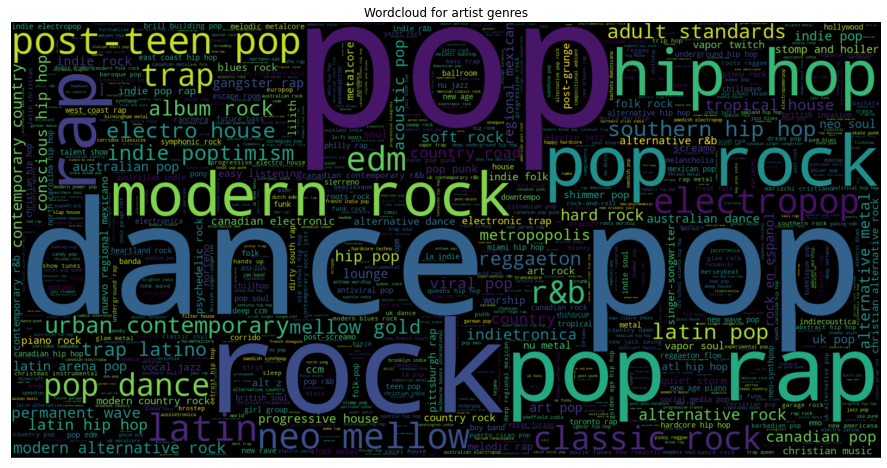

In [ ]:
plt.figure(figsize = (16,8)) 
plt.xticks([], [])  # remove tick markers on x, y axes
plt.yticks([], [])

plt.title("Wordcloud for artist genres")
genres_freqs = pd.Series(pop_artist_genres_flatten).value_counts()
genres, freqs = genres_freqs.index.values, genres_freqs.values
ddd = dict(zip(genres, freqs))
wc_playlistgenres = WordCloud(max_words=1600, width=1600, height=800).generate_from_frequencies(ddd)
plt.imshow(wc_playlistgenres, interpolation='bilinear')
# plt.savefig("wordcloud.png")

The figure has stand out words such as pop, dance, rock and trap. It shows those styles are common in popular playlists and also delivers the information that those are popular perferences. 

# Further Feature Engineering



##Album and Artist information of each Track

For each playlist, we create and compute homogeneity-related values, because we guess that if a playlist is more focused with a theme/topic, it might be more popular or the other way around. 
 - How many tracks in a playlist belong to the same artist? 
   - `track_artist_homo`: this is the ratio of num_tracks to num_artists; if the value is large, then a lot of tracks in the playlist belong to the same artist, meaning that the playlist has a focus on the artist
 - How many tracks in a playlist come from the same album? 
   - `track_album_homo`: this is the ratio of num_tracks to num_albums; if the value is large, then a lot of tracks in the playlist come from the same album, meaning that the playlist has a focus on the album

In [ ]:
# do tracks come from the same album?
# track_album_homo = num_tracks/num_albums
# larger value means higher homogeniety, range from 1 to num_tracks?
df_playlists['track_album_homo'] = df_playlists.num_tracks.values/df_playlists.num_albums.values

# do tracks come from the same artist?
# track_artist_homo = num_tracks/num_artists
# larger value means higher homogeniety, range from 1 to num_tracks?
df_playlists['track_artist_homo'] = df_playlists.num_tracks.values/df_playlists.num_artists.values


df_playlists.iloc[1]

pid                                                              42757
name                                                        volleyball
collaborative                                                     True
modified_at                                                 2017-09-17
duration_s                                                     15934.5
num_edits                                                           10
num_artists                                                         48
artistids            ['6vWDO969PvNqNYHIOW5v0m', '7CajNmpbOovFoOoasH...
num_albums                                                          63
albumids             ['1gIC63gC3B7o7FfpPACZQJ', '3pEgGUv379EDinvg1T...
num_tracks                                                          74
trackids             ['1uXbwHHfgsXcUKfSZw5ZJ0', '0azC730Exh71aQlOt9...
description                                                        NaN
num_followers                                                        4
popula

Text(0, 0.5, 'log_followers')

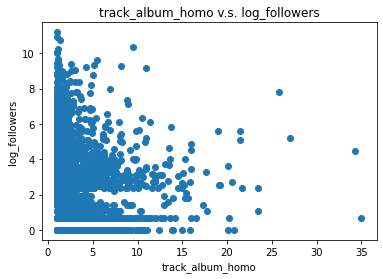

In [ ]:
plt.scatter(df_playlists.num_tracks/df_playlists.num_albums, np.log(df_playlists.num_followers))
plt.title("log_followers v.s. track_album_homo")
plt.xlabel("track_album_homo")
plt.ylabel("log_followers")

In [ ]:
df_playlists['popularity_level'].value_counts()

medium    11338
high       6159
low        3572
Name: popularity_level, dtype: int64

Above we created a scatterplot to see whether or not homogeneity is related to the log number of followers. We also would like to see the difference in homogeneity among different playlist popularity groups. Note that at the beginning, we label playlists with only 1 follower low, playlists with 2 to 10 followers medium, and playlist with more than 10 followers high. Below are the boxplots for homogeneity-related features across different playlist popularity groups.

Text(0, 0.5, 'track_album_homo')

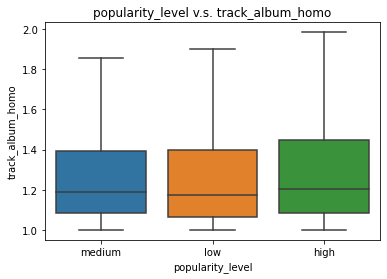

In [ ]:
sns.boxplot(x=df_playlists['popularity_level'], y=df_playlists.num_tracks/df_playlists.num_albums, showfliers=False)
plt.title("popularity_level v.s. track_album_homo")
plt.ylabel("track_album_homo")

Text(0, 0.5, 'log_followers')

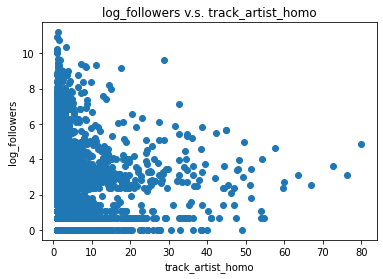

In [ ]:
plt.scatter(df_playlists.num_tracks/df_playlists.num_artists, np.log(df_playlists.num_followers))
plt.title("log_followers v.s. track_artist_homo")
plt.xlabel("track_artist_homo")
plt.ylabel("log_followers")

Text(0, 0.5, 'track_artist_homo')

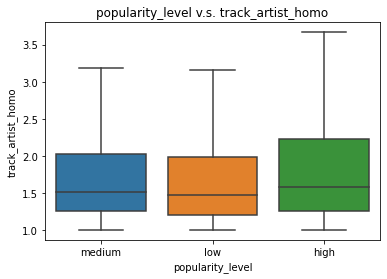

In [ ]:
sns.boxplot(x=df_playlists['popularity_level'], y=df_playlists.num_tracks/df_playlists.num_artists, showfliers=False)
plt.title("popularity_level v.s. track_artist_homo")
plt.ylabel("track_artist_homo")

To further examine whether or not there is a homogeneity difference among playlist popularity groups, we perform Tukey HSD tests. We choose a 95% percent confidence and if a p-value is smaller than 0.05, we mark the respective difference between the groups significant. 


In [ ]:
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_playlists, res_var='track_album_homo', xfac_var='popularity_level', anova_model='track_album_homo ~ C(popularity_level)')
res.tukey_summary

group1 group2      Diff     Lower     Upper   q-value   p-value
0  medium    low  0.059114 -0.525371  0.643600  0.335720  0.900000
1  medium   high  0.139273 -0.132482  0.411028  1.701166  0.453595
2     low   high  0.198387 -0.367559  0.764334  1.163580  0.673051

In [ ]:
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_playlists, res_var='track_artist_homo', xfac_var='popularity_level', anova_model='track_album_homo ~ C(popularity_level)')
res.tukey_summary

group1 group2      Diff     Lower     Upper   q-value   p-value
0  medium    low  0.243755 -0.340731  0.828240  1.384321  0.583750
1  medium   high  0.391818  0.120063  0.663572  4.785904  0.002138
2     low   high  0.635572  0.069626  1.201519  3.727752  0.023152


According to the table, for track_artist_homo, there is significant differences of homogeneity between low popularity playlists and high popularity playlists, and between medium popularity playlists and high popularity playlists.


##Audio features of each Track


In [ ]:
df_audio_feature = pd.read_csv("/content/playlists/audio_features_final.csv",index_col=0)
display(df_audio_feature.info())
display(df_audio_feature.head(5))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331990 entries, 0 to 499
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      331990 non-null  float64
 1   energy            331990 non-null  float64
 2   key               331990 non-null  int64  
 3   loudness          331990 non-null  float64
 4   mode              331990 non-null  int64  
 5   speechiness       331990 non-null  float64
 6   acousticness      331990 non-null  float64
 7   instrumentalness  331990 non-null  float64
 8   liveness          331990 non-null  float64
 9   valence           331990 non-null  float64
 10  tempo             331990 non-null  float64
 11  id                331990 non-null  object 
 12  analysis_url      331990 non-null  object 
 13  duration_ms       331990 non-null  int64  
 14  time_signature    331990 non-null  int64  
dtypes: float64(9), int64(4), object(2)
memory usage: 40.5+ MB


None

danceability  energy  ...  duration_ms  time_signature
0         0.648   0.598  ...       198000               4
1         0.751   0.440  ...       217451               4
2         0.695   0.901  ...       310533               4
3         0.444   0.991  ...       256478               4
4         0.748   0.627  ...       188491               4

[5 rows x 15 columns]

In [ ]:
df_audio_feature = df_audio_feature.rename(columns = {'id':'trackid'})
df_audio_artist = df_track_artist.join(df_audio_feature.set_index('trackid'), on = 'trackid')

In [ ]:
# group by playlist_name: 'artist_popularity', 'artist_followers'
continuous_audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','time_signature']
add_audio_features = df_audio_artist.groupby('pid').mean()[continuous_audio_features]
datacopy = datacopy.join(add_audio_features, on = 'pid')

In [ ]:
datacopy.head()

pid        name  collaborative  ...   valence       tempo  time_signature
0  44429         ACL           True  ...  0.496624  112.689152        3.939394
1  42757  volleyball           True  ...  0.578730  126.167784        4.000000
2  44596        5sos           True  ...  0.578130  117.858900        3.950000
3   1995         woo           True  ...  0.568062  139.976370        3.993151
4  39203     driving           True  ...  0.510073  119.901709        3.984252

[5 rows x 32 columns]

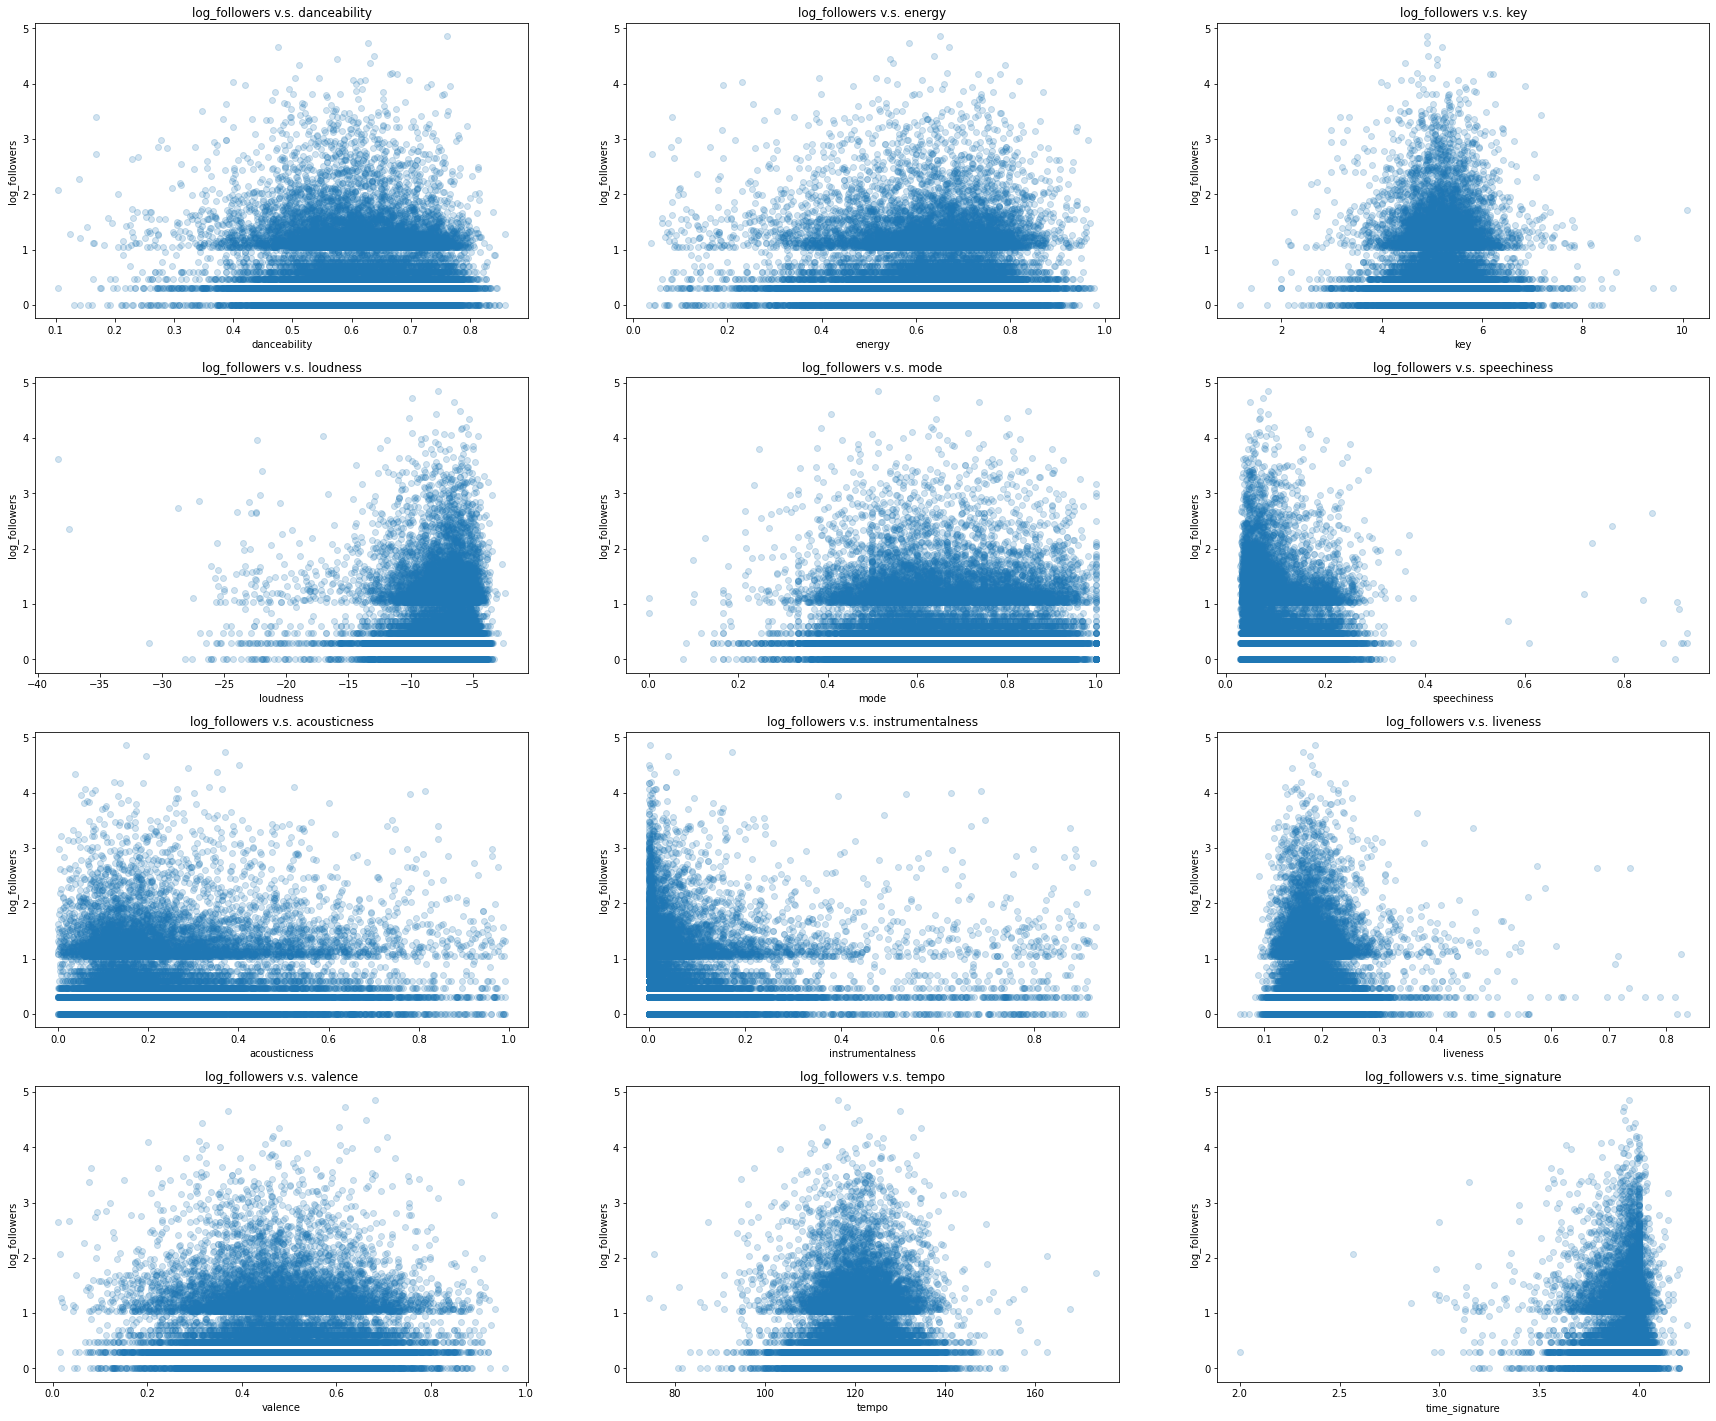

In [ ]:
def continuous_fig(feature,ax):
  ax.scatter(datacopy[feature],datacopy[logresponse],alpha = 0.2)
  ax.set_xlabel(feature)
  ax.set_ylabel(logresponse)
  ax.set_title(f'{logresponse} v.s. {feature}')

fig, axs = plt.subplots(4,3,figsize=(30,25))
# fig.suptitle(f'{logresponse} v.s. continuous features')
ax = axs.flatten()

for a, feature in zip(ax, continuous_audio_features):
  continuous_fig(feature,a)

## Playlist Clustering Based on Description

In [ ]:

# DO NOT NEED TO RUN
tweet = TweetTokenizer()
stopwords = nltk.corpus.stopwords.words('english')
stopwords_self_defined = ["playlist","artist", "song", "track", "album", "music", "remix","mix","feat","edit","original","edm","rock","latin","pop","rap","r&b","music"]
wn = nltk.WordNetLemmatizer()

def clean_description(text):
  if type(text) is not str:
    return text
  CLEANR = re.compile('<.*?>') 
  text = re.sub(CLEANR,"",text)
  text = re.sub("[^-9A-Za-z ]", "" , text)
  text = "".join([i.lower() for i in text if i not in string.punctuation])
  text = tweet.tokenize(text)
  text = [i for i in text if i not in stopwords and i not in stopwords_self_defined]
  text = [wn.lemmatize(word) for word in text]
  text = [word for word in text if len(word) != 1]

  return text
df_combine.description = df_combine.description.apply(clean_description)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (987) found smaller than n_clusters (1000). Possibly due to duplicate points in X.
  if __name__ == '__main__':


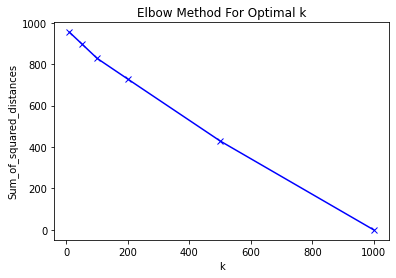

In [ ]:
vectorizer = TfidfVectorizer(stop_words={'english'})
# df_combine.description.apply(lambda x: [] if type(x) is not list else x)
X = vectorizer.fit_transform(df_combine.description.dropna())
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = [10, 50, 100, 200, 500, 1000]
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Cluster: 0
Descriptions
    [great, collection, best, christmas, new, old]
 [unwind, amp, tune, acoustic, piano, guitar, v...
 [light, yacht, everything, best, 99, get, amer...
                                            [best]
                           [learned, best, friend]
               [want, someone, shout, forxs, best]
 [featuring, best, worship, new, chris, tomlin,...
 [hypnotic, electronic, best, mood, staying, fo...
                    [best, electro, house, submit]
                                [prob, best, time]
                    [best, energizing, basketball]
 [best, christmas, every, genre, classic, chris...
                         [personal, best, updated]
 [bringing, best, top, featuring, rapper, futur...
             [time, got, life, best, life, london]
 [best, worst, year, missing, beyonc, kendrick,...
                [best, colloborative, perspective]
     [consists, best, electronic, different, mood]
                            [best, country, drink]
       

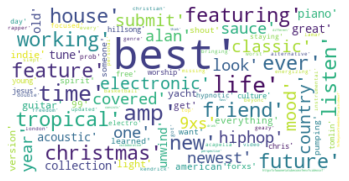

Cluster: 1
Descriptions
 [one, said, life, would, easy, suffer, effect,...
 [like, aesthetic, speculation, xf, ixll, liste...
                         [seem, like, one, better]
 [type, hiphop, finest, slow, rapper, like, fut...
           [one, person, like, rainy, day, little]
 [bunch, listen, writing, figured, others, migh...
       [quotlil, yatchy, look, like, bacteriaquot]
         [idk, feel, like, might, fit, many, mood]
                         [love, like, warmth, day]
        [okay, like, know, like, way, better, yup]
                        [sound, bit, like, winter]
                                     [cause, like]
                      [new, like, updated, weekly]
 [somehow, related, one, another, recently, rel...
                                [like, like, hook]
 [tighten, amp, tone, tuning, tremendous, tune,...
        [list, like, listen, playing, video, game]
                 [pretty, much, immediately, like]
                                            [like]
 [feel,

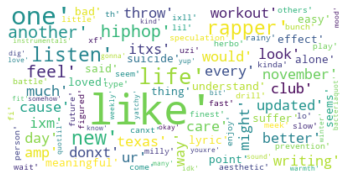

Cluster: 2
Descriptions
                                     [world, need]
       [fall, asleep, listen, sad, getting, ready]
                 [listen, youxre, feelin, someone]
                        [good, old, holiday, vibe]
                          [feel, good, electronic]
 [listen, let, straight, white, man, break, ur,...
                                            [good]
                     [good, work, keep, motivated]
 [xf, would, agree, better, listen, shower, put...
                         [good, running, exercise]
 [rainy, day, good, cup, coffee, indoors, getti...
                                    [need, sorted]
                          [canxt, listen, quietly]
 [listen, summery, soothing, acoustic, driven, ...
                                      [good, vibe]
   [super, chill, vibe, good, getting, work, done]
                                       [good, bye]
 [constantly, added, good, different, genre, se...
 [need, country, tailgate, fire, good, upbeat, ...
       

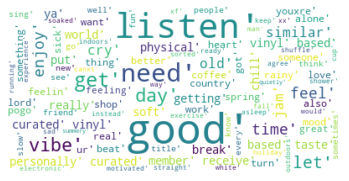

Cluster: 3
Descriptions
      [make, producer, meghan, keane, feel, thing]
                                       [nostalgic]
                     [itxs, quite, lovely, really]
 [fun, make, happy, dance, play, cleaning, enjo...
                                            [feel]
                                      [sad, indie]
 [praise, name, lord, god, xf, praise, name, fo...
                                            [feel]
 [lit, make, feel, pumped, excited, please, enjoy]
                                            [know]
                               [sad, thotty, hour]
                                [itxs, time, work]
     [sing, feel, happy, car, frands, yourselffff]
                               [itxs, complicated]
                             [feel, really, empty]
                     [surf, xf, indie, xf, garage]
   [alt, indie, rampb, soul, sort, thing, updated]
 [sing, day, bring, sad, feel, actually, homework]
           [whatever, cool, storyxs, coming, next]
 [wanna

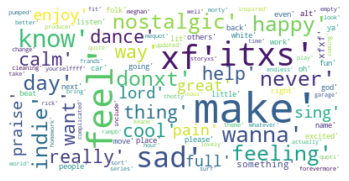

Cluster: 4
Descriptions
                                       [boy, left]
                                          [winter]
                                      [unreadable]
                                [movie, plus, fav]
                                                []
                                         [forever]
 [disneyxs, signature, 99, little, mermaid, moana]
 [trippyxfvibeyxffusionxfchill, thatxll, make, ...
          [doppest, preschool, youxll, ever, hear]
                                                []
                                  [simple, pumpup]
                                            [bomb]
                                    [one, nothing]
                                  [drop, sht, bro]
                  [ocean, noise, beach, amp, rain]
                         [goodness, image, maroon]
 [soundtrack, theory, everything, imitation, ga...
   [nature, sound, another, version, earth, sound]
                                      [chill, man]
     [r

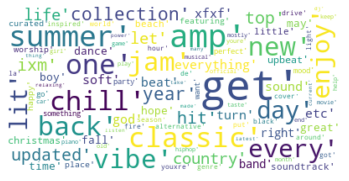

Cluster: 5
Descriptions
                   [twitter, instagram, youtube]
                              [robweak, twitter]
                   [twitter, instagram, youtube]
 [jack, instagram, jack, twitter, jack, youtube]
                   [twitter, instagram, youtube]
                   [twitter, instagram, youtube]
 [jack, instagram, jack, twitter, jack, youtube]
 [jack, instagram, jack, twitter, jack, youtube]
                   [twitter, instagram, youtube]


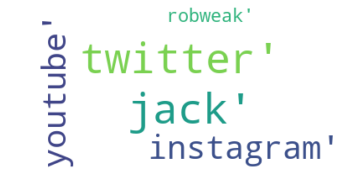

Cluster: 6
Descriptions
                      [favorite, friend, love, lt]
 [collection, favorite, compiled, one, featurin...
  [constantly, changing, current, favorite, indie]
 [standard, study, compilation, vcu, jazz, prog...
                    [favorite, updated, regularly]
                                 [kick, throwback]
                       [favorite, frat, boy, trap]
 [band, spend, lot, time, driving, consists, fa...
 [old, new, steadily, remained, favorite, bring...
                       [favorite, acoustic, cover]
                           [hella, throwback, jam]
     [play, party, annoying, girl, ask, throwback]
                              [personal, favorite]
                        [favorite, washington, dc]
                                        [favorite]
               [ultimate, favorite, stay, updated]
                            [collection, favorite]
 [featuring, elf, soundtrack, vince, guaraldi, ...
                       [favorite, basically, time]
 [hipho

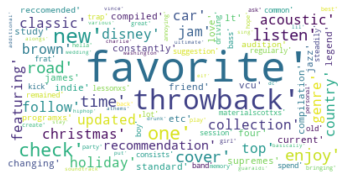

Cluster: 7
Descriptions
 [based, soundtrack, copenhagen, movie, carry, ...
                             [random, love, enjoy]
                                      [love, soul]
 [collection, love, sing, river, west, church, ...
                                   [love, country]
 [full, love, love, listen, want, show, one, da...
 [made, fiancee, little, help, fellow, redditor...
 [ivy, sister, let, speak, soul, never, give, a...
                                 [love, herobrine]
 [hand, best, movie, doesnxt, love, little, rom...
 [awesome, around, got, sad, happy, love, heart...
 [month, sun, kissed, lip, hand, sticky, juice,...
 [believe, love, first, sight, never, stop, loo...
 [come, listen, mulitple, time, going, next, ca...
 [sex, trey, songz, rihanna, minaj, hip, hop, c...
        [itxs, beautiful, thing, fall, back, love]
                                [love, right, one]
         [winston, julia, didnxt, make, love, lie]
 [quoti, broke, heart, hoping, youxd, love, meq...
 [ur, b

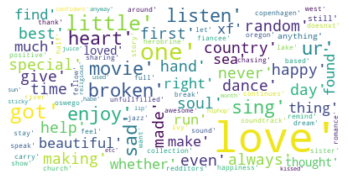

Cluster: 8
Descriptions
                                      [dope, tune]
                         [hardass, tune, gym, rat]
 [need, fresh, tune, got, herexs, fun, lil, dow...
 [classic, folk, tune, plenty, drinking, nice, ...
                     [timeless, tune, bring, back]
        [zone, tune, minimal, jam, maximal, focus]
 [one, girl, tune, make, woman, equality, day, ...
                          [tune, put, mood, write]
                        [tune, enjoy, donxt, suck]
 [crop, fresh, tune, carefully, plucked, audibl...
 [tune, jumpsuit, record, cataloge, offer, slow...
 [place, currently, inspiring, everchanging, cy...
                        [keep, tune, hot, weather]
 [lose, mind, deep, tune, thatxll, thinking, bo...
 [killer, tune, casual, dinner, party, crack, b...
                                       [lit, tune]
 [continually, search, new, tune, may, tickle, ...
                                       [gym, tune]
 [celebrating, harryxs, life, love, tune, bring...
       

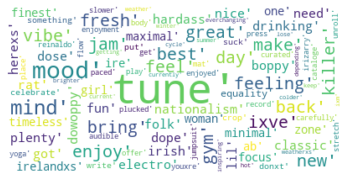

Cluster: 9
Descriptions
 [week, well, adding, favorite, listening, huck...
   [listened, summer, mid, june, start, september]
 [okay, bauces, itxs, time, commit, fitness, st...
 [quotixm, excited, winter, breaki, think, ixm,...
 [preparation, first, listening, quiz, year, st...
 [mixute, various, america, great, start, likin...
                        [listening, harmony, cleo]
 [nice, set, relaxing, instrumentals, getting, ...
 [derrick, amp, klimberly, matter, start, play,...
   [ixm, listening, moment, random, collaboration]
              [calm, start, day, productive, mood]
 [aesthetically, pleasing, mind, start, forget,...
 [worth, listening, right, updated, regularly, ...
                        [start, listening, august]
 [updated, constantly, cleaned, end, month, wid...
 [aerobics, class, zumba, class, whenever, your...
                                  [ixm, listening]
         [ixve, listening, since, moved, brooklyn]
                             [start, year, moving]
 [mixtu

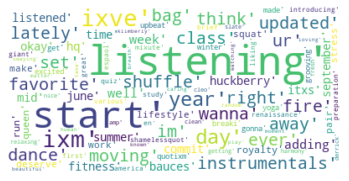

In [ ]:
true_k = 10
vectorizer = TfidfVectorizer(stop_words={'english'})

X = df_combine.description.dropna()
X = X.astype(str)
X = vectorizer.fit_transform(X)
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
cl=pd.concat([pd.DataFrame(df_combine.description.dropna(), columns=['description']).reset_index(),pd.DataFrame(labels,columns=['cluster'])],axis = 1)

for k in range(0,true_k):
   s=cl[cl.cluster==k]
   text=" ".join(s['description'].astype(str).tolist())
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Descriptions')
   titles=cl[cl.cluster==k]['description']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [ ]:

cl_res=pd.DataFrame(labels,columns=['cluster'])
result = pd.concat([df_combine.description.dropna().reset_index(), cl_res], axis=1).set_index("index").drop(columns=["description"])
df_combine_description = df_combine.merge(result, how='outer', left_on=df_combine.index, right_on = result.index).drop(columns=["key_0"])
df_combine_description.cluster = df_combine_description.cluster.fillna(10)df_combine_description.cluster = df_combine_description.cluster.fillna(10)df_combine_description.cluster = df_combine_description.cluster.fillna(10)

## Artist genres

In [ ]:
def get_genres(pid):
    gnr_lists = df_track_artist.artist_genres[df_track_artist.pid == pid].dropna()
    playlist_gnr = '|'.join(gnr_lists).split('|')
    return playlist_gnr
datacopy['genres'] = [get_genres(id) for id in datacopy.pid]

In [ ]:
datacopy.head()

pid  ...                                             genres
0  44429  ...  [garage rock, modern alternative rock, modern ...
1  42757  ...  [conscious hip hop, hip hop, rap, west coast r...
2  44596  ...  [boy band, dance pop, pop, pop rock, post-teen...
3   1995  ...  [emo, modern rock, rock, emo, modern rock, roc...
4  39203  ...  [pop, pop rock, post-teen pop, viral pop, atl ...

[5 rows x 33 columns]

In [ ]:
genres_count = {}
def split_genres(text_list):
  res = []
  for text in text_list:
    if type(text) is not str:
      continue
    text = text.split("|")
    for each in text:
      res.append(each)
      if each in genres_count:
        genres_count[each] += 1
      else:
        genres_count[each] = 1
  return res
df_combine_merged.artist_genres = df_combine_merged.artist_genres.apply(split_genres)

In [ ]:
genres_count = {k: v for k, v in sorted(genres_count.items(), key=lambda item: item[1])}
list(genres_count.items())[3500:]

[('nu-metalcore', 445),
 ('spanish rock', 445),
 ('new orleans funk', 445),
 ('swedish soul', 446),
 ('deep talent show', 446),
 ('australian reggae fusion', 447),
 ('laboratorio', 447),
 ('psychedelic trance', 447),
 ('israeli pop', 449),
 ('canadian classical', 449),
 ('jewish pop', 450),
 ('rap cristiano', 453),
 ('cowpunk', 453),
 ('classic hardstyle', 454),
 ('speedrun', 454),
 ('bakersfield sound', 454),
 ('popping', 457),
 ('experimental r&b', 457),
 ('sufi', 457),
 ('ska revival', 460),
 ('nashville singer-songwriter', 463),
 ('uk doom metal', 464),
 ('uk hip hop', 464),
 ('traditional country', 464),
 ('shimmer psych', 465),
 ('modern ska punk', 465),
 ('cowboy western', 466),
 ('djent', 466),
 ('freestyle', 466),
 ('neo r&b', 469),
 ('german baroque', 471),
 ('brazilian rock', 476),
 ('cedm', 478),
 ('lds', 479),
 ('welsh rock', 480),
 ('panamanian pop', 480),
 ('german rock', 481),
 ('focus', 485),
 ('swedish tropical house', 489),
 ('nintendocore', 489),
 ('ecuadorian pop',

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
genres_words = {}
for key in genres_count.keys():
  for w in key.split(" "):
    if w in genres_words:
      genres_words[w] += genres_count[key]
    else:
      genres_words[w] = genres_count[key]
genres_words_count = {k: v for k, v in sorted(genres_words.items(), key=lambda item: item[1]) if k not in stopwords}

genres_words_top = list(genres_words_count.keys())[-50:]

In [ ]:
genres_words_top_list = list(genres_words_count.items())[-50:]
genres_words_top_ratio = {}
sum = 0
for k, v in genres_words_top_list:
  sum += v
print(sum)

10838517


In [ ]:
for k, v in genres_words_top_list:
  genres_words_top_ratio[k] = v / sum

max_ =  np.max(list(genres_words_top_ratio.values()))
min_ =  np.min(list(genres_words_top_ratio.values()))
for k, v in genres_words_top_list:
  genres_words_top_ratio[k] = 100 * (genres_words_top_ratio[k] - min_) / (max_ - min_)

In [ ]:
genres_words_top_ratio

{'album': 0.3981625662653883,
 'alternative': 10.237567920458726,
 'art': 0.3679540608186779,
 'atl': 1.071539637954122,
 'australian': 0.0,
 'blues': 0.5288435594409368,
 'canadian': 4.388300017746802,
 'ccm': 0.06803867801349278,
 'christian': 2.558766113289128,
 'classic': 3.327775635922419,
 'coast': 0.21017998817250777,
 'contemporary': 8.0542106372882,
 'country': 17.14307649427791,
 'dance': 21.78984560282658,
 'edm': 4.72120553633449,
 'electro': 1.7065302110089138,
 'electropop': 2.9979299107041033,
 'folk': 3.5688317208222275,
 'funk': 0.10926243958994278,
 'gangster': 0.7751847419787514,
 'gold': 0.9320130603107526,
 'hip': 40.206686260470754,
 'holler': 0.24033286101250198,
 'hop': 38.10433005267852,
 'house': 9.984884620755302,
 'indie': 14.907869621648205,
 'jazz': 0.07905393414323235,
 'latin': 3.111865489258178,
 'mellow': 4.5918040931134065,
 'metal': 4.368772972789536,
 'modern': 9.99968289414172,
 'neo': 2.414955824928637,
 'new': 3.6098885845785302,
 'pop': 100.0,
 

In [ ]:
def get_genres_dummy(texts):
  res = []
  for text in texts:
    for t in text.split(" "):
      if t in genres_words_top:
        res.append(t)
  return res
s = df_combine_merged.artist_genres.apply(get_genres_dummy)
mlb = MultiLabelBinarizer()
dummies = mlb.fit_transform(s)


In [ ]:

columns=mlb.classes_
df_dummies = pd.DataFrame(dummies, columns=columns)
s_count = s.apply(Counter)
for i, dict_genres in enumerate(s_count):
  for k, v in dict_genres.items():
      df_dummies[k][i] = df_dummies[k][i]*v*genres_words_top_ratio[k]
df_dummies

album  alternative  art  atl  ...  uk  urban  wave  worship
0          0          153    0    0  ...   0      0     5        0
1          0           20    0    2  ...   0     16     0        0
2          0            0    0    0  ...   0      1     0        0
3          0          348    0    0  ...   0      0    21        0
4          5          522    1    3  ...   0      4     9        0
...      ...          ...  ...  ...  ...  ..    ...   ...      ...
21064      0           10    0   43  ...   0      6     0        0
21065      0            0    0    0  ...   0      4     0        0
21066      0           51    0    0  ...   2      0     0        0
21067      0           51    1    0  ...   0      0     3        0
21068      0            0    0    0  ...   0      0     0        0

[21069 rows x 50 columns]

In [ ]:
df_dummies.to_csv("playlists/dummies_scores.csv")
df_combine_merged_genres = pd.concat([df_combine_merged, df_dummies.add_prefix('genres_score_')],axis = 1)
df_combine_merged_genres = df_combine_merged_genres.drop(columns = ["genres_" + x for x in columns])

df_combine_merged_genres.head()


pid        name  ...  genres_score_wave  genres_score_worship
0  44429         ACL  ...                  5                     0
1  42757  volleyball  ...                  0                     0
2  44596        5sos  ...                  0                     0
3   1995         woo  ...                 21                     0
4  39203     driving  ...                  9                     0

[5 rows x 83 columns]

# Modeling

We use our combined dataset to train the final model.

This dataset contain both the original features the features we created.

In [ ]:
df_model = pd.read_csv("/content/playlists/playlist_combine_genres_scores.csv",index_col=0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21069 entries, 0 to 21068
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   duration_s                 21069 non-null  float64
 1   num_edits                  21069 non-null  int64  
 2   num_artists                21069 non-null  int64  
 3   num_albums                 21069 non-null  int64  
 4   num_tracks                 21069 non-null  int64  
 5   num_followers              21069 non-null  int64  
 6   popularity_level           21069 non-null  object 
 7   have_description           21069 non-null  bool   
 8   log_followers              21069 non-null  float64
 9   artist_popularity          21069 non-null  float64
 10  artist_followers           21069 non-null  float64
 11  track_album_homo           21069 non-null  float64
 12  track_artist_homo          21069 non-null  float64
 13  danceability               21069 non-null  flo

In [ ]:
df_model.head()

duration_s  num_edits  num_artists  ...  cluster_8.0  cluster_9.0  cluster_10.0
0    7544.545          2           33  ...            0            0             1
1   15934.511         10           48  ...            0            0             1
2    4394.661          2           17  ...            0            0             1
3   29183.178         13           24  ...            0            0             1
4   30924.099         82           97  ...            0            0             1

[5 rows x 87 columns]

Split train and test set, stratify by `popularity_level`

In [ ]:
playlists_train, playlists_test = train_test_split(df_model, train_size=0.75, random_state=66,stratify=df_combine['popularity_level'])

In [ ]:
catogrical_response = 'popularity_level'
logresponse = 'log_followers'
response = 'num_followers'

In [ ]:
X_train = playlists_train.drop(columns=[catogrical_response, logresponse, response])
y_train = playlists_train[['log_followers']]
X_test = playlists_test.drop(columns=[catogrical_response, logresponse, response])
y_test = playlists_test[['log_followers']]

Use `MinMaxScaler` to scale the data

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Linear Model

We use a simple linear model as our baseline. Just take in all the features after feature engineering

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
r2_train = lr.score(X_train, y_train)
r2_test = lr.score(X_test, y_test)
print("Score for Model (Training):", r2_train)
print("Score for Model (Testing) :", r2_test)

Score for Model (Training): 0.09535346255071597
Score for Model (Testing) : 0.08965007451187224


## Random Forest

Then try to build a random forest model.
We planned to do grid search, but after feature engineering,there are too many features, and grid search may be time-costly. So we choose the parameter based on several tests.

In [ ]:
model_rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=3, max_depth=15)
model_rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=300)

In [ ]:
y_pred_train2 = model_rf.predict(X_train_scaled)
y_pred_test2 = model_rf.predict(X_test_scaled)
r2_train2 = model_rf.score(X_train_scaled, y_train)
r2_test2 = model_rf.score(X_test_scaled, y_test)
mse_test2 = mean_squared_error(y_test, y_pred_test2)
print(f"r2 score for RF model (Training): {r2_train2:.5f}")
print(f"r2 score for RF model (Testing) : {r2_test2:.5f}")
print(f"MSE for RF model (Testing)      : {mse_test2:.5f}")

r2 score for RF model (Training): 0.50073
r2 score for RF model (Testing) : 0.11648
MSE for RF model (Testing)      : 0.34294


Then take a look at the feature importance

In [ ]:
feature_importance = list(zip(X_train.columns[0:], model_rf.feature_importances_))

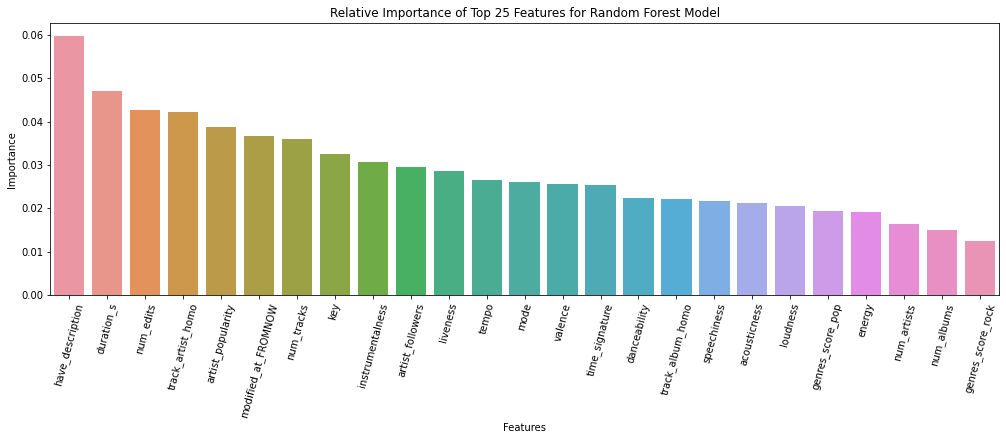

In [ ]:
plt.figure(figsize=(17,5))
sns.barplot(x=[item[0] for item in (sorted(feature_importance, key=lambda x:x[1], reverse=True)[:25])], 
            y = [item[1] for item in (sorted(feature_importance, key=lambda x:x[1], reverse=True)[:25])])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Importance of Top 25 Features for Random Forest Model')
plt.xticks(rotation=75);

## XGBoost

Then we planned to build some boosting model. But Gradient Boost takes a lot of time, we choose XGBoost since it is fast and paralleled, which is more suitable to do gridsearch. And XGBoost uses pre-sorted algorithm & histogram-based algorithm for computing the best split, which is also great for model performance.


In [ ]:
xgbr = XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07, .1], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,200,500,1000]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_scaled,
         y_train)

print('best params: ' + str(xgb_grid.best_params_))
print('score for best_params: ' + str(xgb_grid.score(X_train_scaled,y_train)))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
score for best_params: 0.18868194646000547


In [ ]:
xgbr = XGBRegressor(nthread=4,objective='reg:linear',learning_rate=.03,max_depth=3,min_child_weight=4,silent=1
                    ,subsample=0.7,colsample_bytree=0.7,n_estimators=500)

# gdb = GradientBoostingRegressor(max_depth=3,learning_rate=0.1,n_estimators=100)
xgbr.fit(X_train_scaled,y_train)
# y_pred = gdb.predict(X_test_scaled)
train_score = xgbr.score(X_train_scaled,y_train)
test_score = xgbr.score(X_test_scaled,y_test)
print("Score for Model (Training):", train_score)
print("Score for Model (Testing) :", test_score)

Score for Model (Training): 0.18868194646000547
Score for Model (Testing) : 0.11362714260694007


In [ ]:
feature_importance = list(zip(X_train.columns[0:],xgbr.feature_importances_))

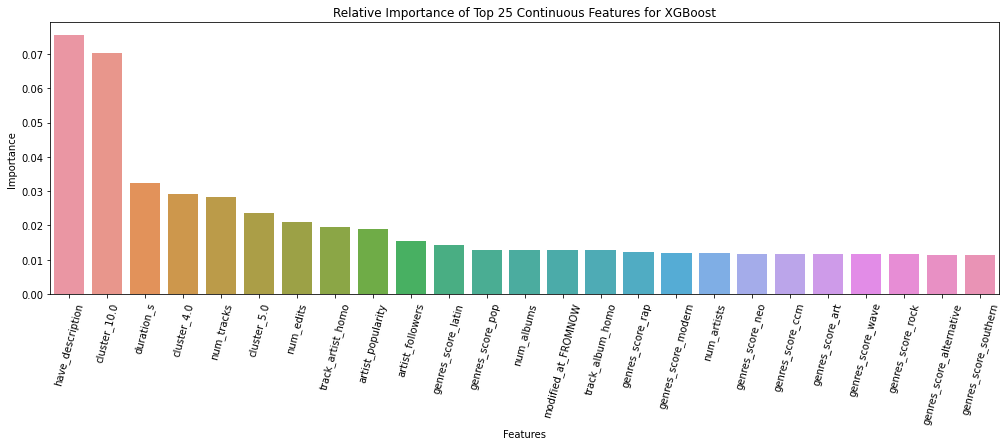

In [ ]:
plt.figure(figsize=(17,5))
sns.barplot(x=[item[0] for item in (sorted(feature_importance,key=lambda x:x[1], reverse=True)[:25])], 
                y = [item[1] for item in (sorted(feature_importance,key=lambda x:x[1], reverse=True)[:25])])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Importance of Top 25 Continuous Features for XGBoost')
plt.xticks(rotation=75);

## LightGBM

Also, we tried LightGBM, since it is a fast, distributed, high-performance and high-compatibility boosting method, which runs much faster and reaches better performance.


In [ ]:
model = LGBMRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.7],
    'max_depth': [3,5,10],
    'num_leaves': [50, 100],
    'reg_alpha': [1.1, 1.3],
    'reg_lambda': [1.1, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.9],
    'subsample_freq': [20]
}

lgbm_grid = GridSearchCV(model,
                        param_grid,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

lgbm_grid.fit(X_train_scaled,y_train)

print('best params: ' + str(lgbm_grid.best_params_))
print('score for best_params: ' + str(lgbm_grid.score(X_train_scaled,y_train)))

train_score = lgbm_grid.score(X_train_scaled,y_train)
test_score = lgbm_grid.score(X_test_scaled,y_test)
print("Score for Model (Training):", train_score)
print("Score for Model (Testing) :", test_score)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best params: {'colsample_bytree': 0.7, 'max_depth': 3, 'min_split_gain': 0.3, 'n_estimators': 200, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 1.3, 'subsample': 0.9, 'subsample_freq': 20}
score for best_params: 0.18892755362916402
Score for Model (Training): 0.18892755362916402
Score for Model (Testing) : 0.1117621312913506


In [ ]:
lgbm = LGBMRegressor(n_estimators=200,colsample_bytree=0.7,max_depth=3,reg_alpha=1.3,reg_lambda=1.3,min_split_gain=0.3,
                     subsample = 0.9,subsample_freq = 20,num_leaves = 50)
# gdb = GradientBoostingRegressor(max_depth=3,learning_rate=0.1,n_estimators=100)
lgbm.fit(X_train_scaled,y_train)
# y_pred = gdb.predict(X_test_scaled)
train_score = lgbm.score(X_train_scaled,y_train)
test_score = lgbm.score(X_test_scaled,y_test)
print("Score for Model (Training):", train_score)
print("Score for Model (Testing) :", test_score)

Score for Model (Training): 0.18892755362916402
Score for Model (Testing) : 0.1117621312913506


In [ ]:
feature_importance = list(zip(X_train.columns[0:],lgbm.feature_importances_))

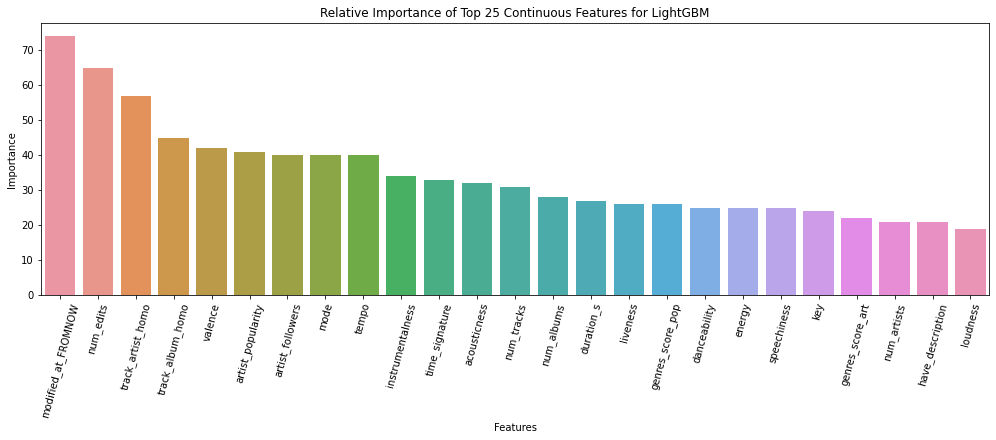

In [ ]:
plt.figure(figsize=(17,5))
sns.barplot(x=[item[0] for item in (sorted(feature_importance,key=lambda x:x[1], reverse=True)[:25])], 
                y = [item[1] for item in (sorted(feature_importance,key=lambda x:x[1], reverse=True)[:25])])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Importance of Top 25 Continuous Features for LightGBM')
plt.xticks(rotation=75);

## Winner Model

### Random Forest

 - $R^2$ score for RF model (Training): 0.50073
 - $R^2$ score for RF model (Testing) : 0.11648 

### Feature Importance

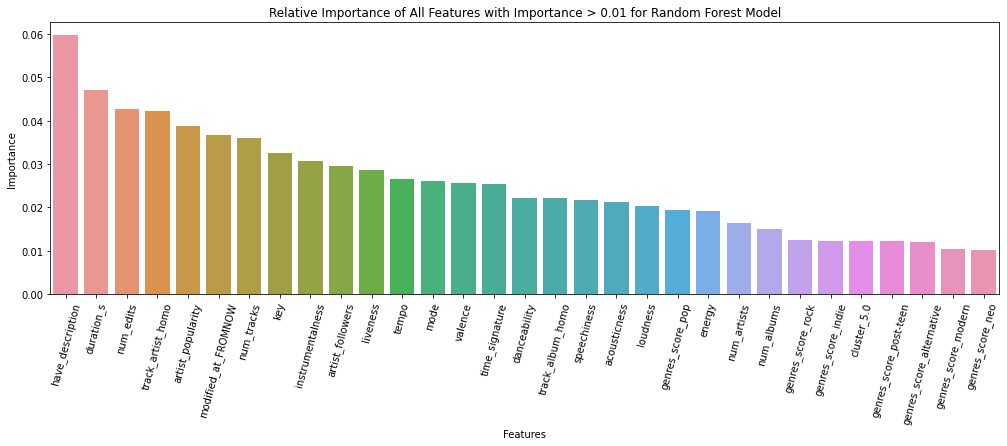

In [ ]:
plt.figure(figsize=(17,5))
first_idx_no_001 = sum(model_rf.feature_importances_ > 0.01)
sns.barplot(x = [item[0] for item in (sorted(feature_importance, key=lambda x:x[1], reverse=True)[:first_idx_no_001])], 
            y = [item[1] for item in (sorted(feature_importance, key=lambda x:x[1], reverse=True)[:first_idx_no_001])])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Importance of All Features with Importance > 0.01 for Random Forest Model')
plt.xticks(rotation=75);

- `have_description` are the most important feature
- Also, the features we added, `track_artist_homo`, `artist popularity`, `artist followers`, `track_album_homo`, `modified_at_FROMNOW` and these audio features are also more important.



Even the best model has a really poor performance in predicting the log number of followers of the playlists. There are still much space for improvement, either by getting more informative data and building better models.
We speculate that playlist popularity can be related to playlist creators’ popularity. If we are able to retrieve features related to users who created the playlists, we might be able to improve the performance of the model. However, if this strongly boost model performance, models are less focused on exploring what playlist characteristics make them popular, and perhaps popularity of a playlist does not really depend on its own characteristics but more on the popularity and publicity of the creators, and this might mean that there is much space for Spotify to improve the recommendation system so that playlists created by non-popular users can also get noticed. 


